In [4]:
import argparse
import os
import pickle

import torch as T
import yaml
from torch.optim import Adam
from tqdm import tqdm

import sys

sys.path.append('/Users/marcelloceresini/github/FSOD_CenterNet/src')
from data_pipeline import DatasetsGenerator
from model import Model


def load_settings(settings_path: str):
    with open(settings_path, 'r') as f:
        return yaml.safe_load(f)
    
settings = '../settings/model_testing_debug_check.yaml'
    
config = load_settings(settings)

if os.path.exists(config['training']['save_base_weights_dir']) \
                and config["training"]["train_base"] \
                and config["training"]["no_overwrite"]:
    raise ValueError("Cannot overwrite weights")

os.makedirs(config['training']['save_training_info_dir'], exist_ok=True)

debug_mode = config['debug']['debug_mode_active']
device = config['device']

K = config['data']['K']
val_K = config['data']['val_K']
test_K = config['data']['test_K']
n_repeats_novel_train = config['training']['repeat_novel_training']

if isinstance(K, int): K = [K]
if isinstance(val_K, int): val_K = [val_K]
if isinstance(test_K, int): test_K = [test_K]

# Dataset generator. Only one of these has to be instantiated. It always returns
dataset_gen = DatasetsGenerator(config)

if config['training']['train_base']:

    # Instantiate the model (only the base part)
    model = Model(config, n_base_classes=len(dataset_gen.train_base.cats))
    model = model.to(device)

    # Use the dataset generator to generate the base set
    dataset_base_train, dataset_base_val, dataset_base_test = dataset_gen.get_base_sets_dataloaders(
        config['training']['batch_size'], config['training']['num_workers'],
        config['training']['pin_memory'], config['training']['drop_last'], 
        shuffle=True
    )
    

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=3.36s)
creating index...
index created!
Skipping instantating novel head


In [5]:
model.load_state_dict(T.load('../../data/weights/from_server/best_model_fix_stoic.pt', map_location="cpu"))

<All keys matched successfully>

In [6]:
import numpy as np
params = sum([np.prod(p.size()) for p in model.parameters()])
params

13806677

In [7]:
sum([np.prod(p.size()) for p in model.encoder.parameters()])

11176512

In [8]:
for i, (input_image, labels, n_detections, _) in enumerate(dataset_base_train):
    out = model(input_image.to(device))
    break

In [9]:
out_reg, out_head_base, _ = out
regressor_label, heatmap_base, _ = labels

In [10]:
# regressor_label.shape

In [11]:
# out_reg[T.where(regressor_label != 0)].shape
# out_reg[T.where(regressor_label != 0)].reshape(-1, 4)[:10]

In [12]:
regressor_label[T.where(regressor_label != 0)].reshape(-1, 4)[:10]

tensor([[ 6.3915, 20.9214,  9.0986, 21.9729],
        [ 0.4394,  0.7470,  0.5082,  0.8544]])

In [13]:
out_head_base[T.where(heatmap_base==1)]

tensor([0.0030, 0.1295], grad_fn=<IndexBackward0>)

In [14]:
out_head_base.max(), out_head_base.min(), out_head_base.mean()

(tensor(0.2934, grad_fn=<MaxBackward1>),
 tensor(0.0003, grad_fn=<MinBackward1>),
 tensor(0.0027, grad_fn=<MeanBackward0>))

In [15]:
heatmap_base.max(), heatmap_base.min(), heatmap_base.mean()

(tensor(1.), tensor(0.), tensor(0.0008))

In [16]:
def heatmap_loss(pred_heatmap, gt_heatmap, num_keypoints, config):
    gt_heatmap = gt_heatmap.to(pred_heatmap.device)
    num_keypoints = num_keypoints.to(pred_heatmap.device)

    loss = T.where(
        gt_heatmap == 1,
        (1 - pred_heatmap) ** config['model']['alpha_loss'] * T.log(pred_heatmap),
        (1 - gt_heatmap) ** config['model']['beta_loss'] * \
            (pred_heatmap) ** config['model']['alpha_loss'] * T.log(1 - pred_heatmap),
    ).reshape(pred_heatmap.shape[0], -1).sum(dim=-1)

    result = T.where(
        num_keypoints != 0,
        input = loss / num_keypoints,
        other = 0
    )

    return -result

In [17]:
pred_heatmap = out_head_base
gt_heatmap = heatmap_base
num_keypoints = n_detections

gt_heatmap = gt_heatmap.to(pred_heatmap.device)
num_keypoints = num_keypoints.to(pred_heatmap.device)

a1 = (1 - pred_heatmap) ** config['model']['alpha_loss'] * T.log(pred_heatmap)
a2 = (1 - gt_heatmap) ** config['model']['beta_loss'] * (pred_heatmap) ** config['model']['alpha_loss'] * T.log(1 - pred_heatmap)

a1.max(), a1.mean()

(tensor(-0.6124, grad_fn=<MaxBackward1>),
 tensor(-6.0811, grad_fn=<MeanBackward0>))

In [18]:
a1.shape

torch.Size([1, 240, 32, 32])

In [19]:
a2.mean(), a2.min()

(tensor(-1.7145e-06, grad_fn=<MeanBackward0>),
 tensor(-0.0299, grad_fn=<MinBackward1>))

In [20]:
heatmap_loss(out_head_base, heatmap_base, n_detections, config)

tensor([3.8673], grad_fn=<NegBackward0>)

In [21]:
(32*32-1)*-1.0031e-07

-0.00010261713

In [22]:
import torch.nn.functional as NNF
import torch as T
from torchmetrics.detection import MeanAveragePrecision

@T.no_grad()
def get_heatmap_maxima_idxs(complete_heatmaps):
    pooled_heatmaps = NNF.max_pool2d(complete_heatmaps,
                                    3,
                                    stride=1,
                                    padding=1)
    return (complete_heatmaps == pooled_heatmaps)

def landmarks_from_idxs(regressor_pred: T.tensor,
                        complete_heatmaps: T.tensor,
                        idxs_tensor_mask: T.tensor):
    n_classes, output_width, output_height = idxs_tensor_mask.shape

    num_detections = T.sum(idxs_tensor_mask).to('cpu')
    num_detections = min(100, num_detections) # 10 MAXIMUM DETECTIONS FOR VISUALIZATION
    
    landmarks_pred = {
        "boxes": T.zeros(num_detections,4),
        "labels": T.zeros(num_detections).to(T.int32),
        "scores": T.zeros(num_detections)
    }

    # Flattens it so we can use topk
    confidence_scores = T.masked_select(complete_heatmaps, idxs_tensor_mask)

    # The i-th element in top_k_scores has the i-th highest confidence score in the image, 
    # but its index refers to its position in "confidence_scores" (which is a flattened tensor
    # tthat has as many elements as idxs_tensor_mask's true values, or peaks).
    # Instead, we will need a n_classes*output_width*output_height tensor to get indices
    top_k_scores = T.topk(confidence_scores, num_detections)
    
    # This retrieves all of the (flattened) indices (of the output image) where the classification has a peak
    flattened_idxs = T.nonzero(T.flatten(idxs_tensor_mask)).reshape(-1)

    # this retrieves only the top "num_detections" of them (but still, flattened)
    flattened_top_k_idxs = flattened_idxs[top_k_scores.indices]

    base_mask = T.zeros(n_classes*output_width*output_height).to(device='cpu')
    # Populates the mask with 1s for topk indices
    base_mask[flattened_top_k_idxs] += 1
    mask = base_mask.to(dtype=T.bool)

    top_k_mask = T.unflatten(mask, dim=0, sizes=(n_classes, output_width, output_height))
    top_k_idxs = T.nonzero(top_k_mask)

    print(top_k_idxs)

    regressor_pred_repeated = regressor_pred.repeat(n_classes,1,1,1)

    size_x = T.masked_select(regressor_pred_repeated[:,0,:,:],
                                top_k_mask)
    size_y = T.masked_select(regressor_pred_repeated[:,1,:,:],
                                top_k_mask)
    off_x = T.masked_select(regressor_pred_repeated[:,2,:,:],
                                top_k_mask)
    off_y = T.masked_select(regressor_pred_repeated[:,3,:,:],
                                top_k_mask)

    category = top_k_idxs[:,0]
    center_idx_y = top_k_idxs[:,1]
    center_idx_x = top_k_idxs[:,2]

    center_coord_x = center_idx_x+off_x
    center_coord_y = center_idx_y+off_y

    for i, (c, cx, cy, sx, sy, score) in \
        enumerate(zip(category, center_coord_x, center_coord_y, size_x, size_y, confidence_scores)):

            landmarks_pred["boxes"][i,0] = cx
            landmarks_pred["boxes"][i,1] = cy
            landmarks_pred["boxes"][i,2] = sx
            landmarks_pred["boxes"][i,3] = sy
            landmarks_pred["labels"][i] = c
            landmarks_pred["scores"][i] = score

    return landmarks_pred

In [23]:
for counter, (image_batch, label_batch, n_landmarks_batch, padded_landmarks) in enumerate(dataset_base_train):

    # both image and landmarks will be resized to model_input_size
    reg_pred_batch, heat_base_pred_batch, heat_novel_pred_batch = model(image_batch.to('cpu'))

    list_landmarks_pred = []
    list_landmarks_gt = []
    
    for i, (reg_pred, heat_base_pred, n_landmarks) in \
        enumerate(zip(reg_pred_batch, heat_base_pred_batch, n_landmarks_batch)):
        complete_heatmaps = heat_base_pred

        idxs_tensor = get_heatmap_maxima_idxs(complete_heatmaps)

        landmarks_pred = landmarks_from_idxs(
            reg_pred,
            complete_heatmaps,
            idxs_tensor
        )

        landmarks_gt = {
            "boxes": padded_landmarks["boxes"][i,:n_landmarks,:],
            "labels": padded_landmarks["labels"][i,:n_landmarks]
        }

        list_landmarks_pred.append(landmarks_pred)
        list_landmarks_gt.append(landmarks_gt)

    break

tensor([[  0,  12,  13],
        [  1,  12,  13],
        [  2,  12,  13],
        [  7,  12,  13],
        [ 13,  12,  13],
        [ 16,  12,  13],
        [ 17,  12,  13],
        [ 19,  12,  13],
        [ 23,  12,  13],
        [ 26,  12,  13],
        [ 31,  12,  13],
        [ 36,  12,  13],
        [ 38,  13,  13],
        [ 40,  12,  13],
        [ 40,  14,  23],
        [ 43,  12,  13],
        [ 49,  12,  13],
        [ 51,  12,  13],
        [ 55,  12,  13],
        [ 56,  13,  13],
        [ 57,  13,  13],
        [ 58,  12,  13],
        [ 60,  12,  13],
        [ 62,  12,  13],
        [ 70,  12,  13],
        [ 71,  13,  13],
        [ 72,  12,  13],
        [ 73,  12,  13],
        [ 75,  12,  13],
        [ 77,  12,  13],
        [ 77,  14,  23],
        [ 82,  12,  13],
        [ 83,  12,  13],
        [ 85,  12,  13],
        [ 86,  12,  13],
        [ 87,  12,  13],
        [ 87,  14,  23],
        [ 91,  12,  13],
        [ 91,  14,  23],
        [ 94,  12,  13],


In [24]:
range(len(list_landmarks_pred[0]["labels"]))

range(0, 100)

In [25]:
def box_and_label_from_landmarks(list_landmarks_unbacthed, max_img_size):
    list_boxes = []
    list_labels = []

    for i in range(len(list_landmarks_unbacthed["labels"])):
        list_boxes.append(T.tensor([
            max(0, 4*(list_landmarks_unbacthed["boxes"][i][0]-list_landmarks_unbacthed["boxes"][i][2])),
            max(0, 4*(list_landmarks_unbacthed["boxes"][i][1]-list_landmarks_unbacthed["boxes"][i][3])),
            min(max_img_size-1, 4*(list_landmarks_unbacthed["boxes"][i][0]+list_landmarks_unbacthed["boxes"][i][2])),
            min(max_img_size-1, 4*(list_landmarks_unbacthed["boxes"][i][1]+list_landmarks_unbacthed["boxes"][i][3])),
                           ]))
        list_labels.append(str(list_landmarks_unbacthed["labels"][i].item()))

    if len(list_boxes)>1:
        list_boxes = T.stack(list_boxes)

    else:
        list_boxes = list_boxes[0].reshape(1,4)
    

    return list_boxes, list_labels

In [26]:
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert

def showgrid(img, heat_gt, heat_pred, land_gt, land_pred):

    batch_size = img.shape[0]
    print()
    f, axarr = plt.subplots(5+10, batch_size, constrained_layout=True, figsize=(13,17))

    # (xmin, ymin, xmax, ymax)

    for b in range(batch_size):

        print(T.max(heat_pred[b]))
        heat_pred[b][:,0,0] = (T.ones_like(heat_pred[b][:,0,0])*T.max(heat_pred[b]))

        # boxes, labels = box_and_label_from_landmarks(land_gt[b], img.shape[-1])
        # print(boxes)
        img_to_plot = draw_bounding_boxes(
            (img[b]*256).to(T.uint8), 
            boxes=box_convert(land_gt[b]["boxes"], in_fmt="cxcywh", out_fmt="xyxy")
        )
        axarr[0,b].imshow(F.to_pil_image(img_to_plot))

        # boxes, labels = box_and_label_from_landmarks(land_pred[b], img.shape[-1])

        boxes = land_pred[b]["boxes"]

        img_to_plot = draw_bounding_boxes(
            (img[b]*256).to(T.uint8), 
            boxes=box_convert(boxes, 
                              in_fmt="cxcywh", 
                              out_fmt="xyxy")
        ) # I ADDED A *4 BUT I'M NOT SURE IT IS NEEDED
        axarr[1,b].imshow(F.to_pil_image(img_to_plot))
        
        axarr[2,b].imshow(F.to_pil_image(T.max(heat_gt[1][b], dim=0).values))
        axarr[3,b].imshow(F.to_pil_image(T.max(heat_pred[b], dim=0).values))

        tmp_label = land_gt[b]["labels"][0]
        axarr[4,b].imshow(F.to_pil_image(heat_pred[b][tmp_label]))


        n_label_gt = 0
        
        c_right = 0
        mean_score_right = 0
        c_wrong = 0
        mean_score_wrong = 0
        
        for label_gt in land_gt[b]["labels"]:
            n_label_gt+=1
            for label_pred, score in zip(land_pred[b]["labels"], land_pred[b]["scores"]):
                if label_gt == label_pred:
                    c_right+=1
                    mean_score_right += score.item()
                else:
                    c_wrong+=1
                    mean_score_wrong += score.item()

        c_right /= n_label_gt
        mean_score_right /= n_label_gt
        if c_right != 0:
            mean_score_right /= c_right
            
        c_wrong /= n_label_gt
        mean_score_wrong /= n_label_gt
        if c_wrong != 0:
            mean_score_wrong /= c_wrong
        print("Image ", b+1, " - Right ", c_right, " - Mean Score ", mean_score_right, " - Wrong ", c_wrong, " - Mean Score ", mean_score_wrong)

        # for i, rand_label in enumerate(T.randint(240, (5,1))):
        #     axarr[5+i,b].imshow(F.to_pil_image(heat_gt[1][b][rand_label]))

    
        for i, rand_label in enumerate(T.randint(240, (10,1))):
            axarr[5+i,b].imshow(F.to_pil_image(heat_pred[b][rand_label]))

    
    for b in axarr.flat:
        plt.axis('on')
        b.set_xticks([])
        b.set_yticks([])

    print("Before plot")
    plt.show()
    print("After plot")



tensor(0.1527)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

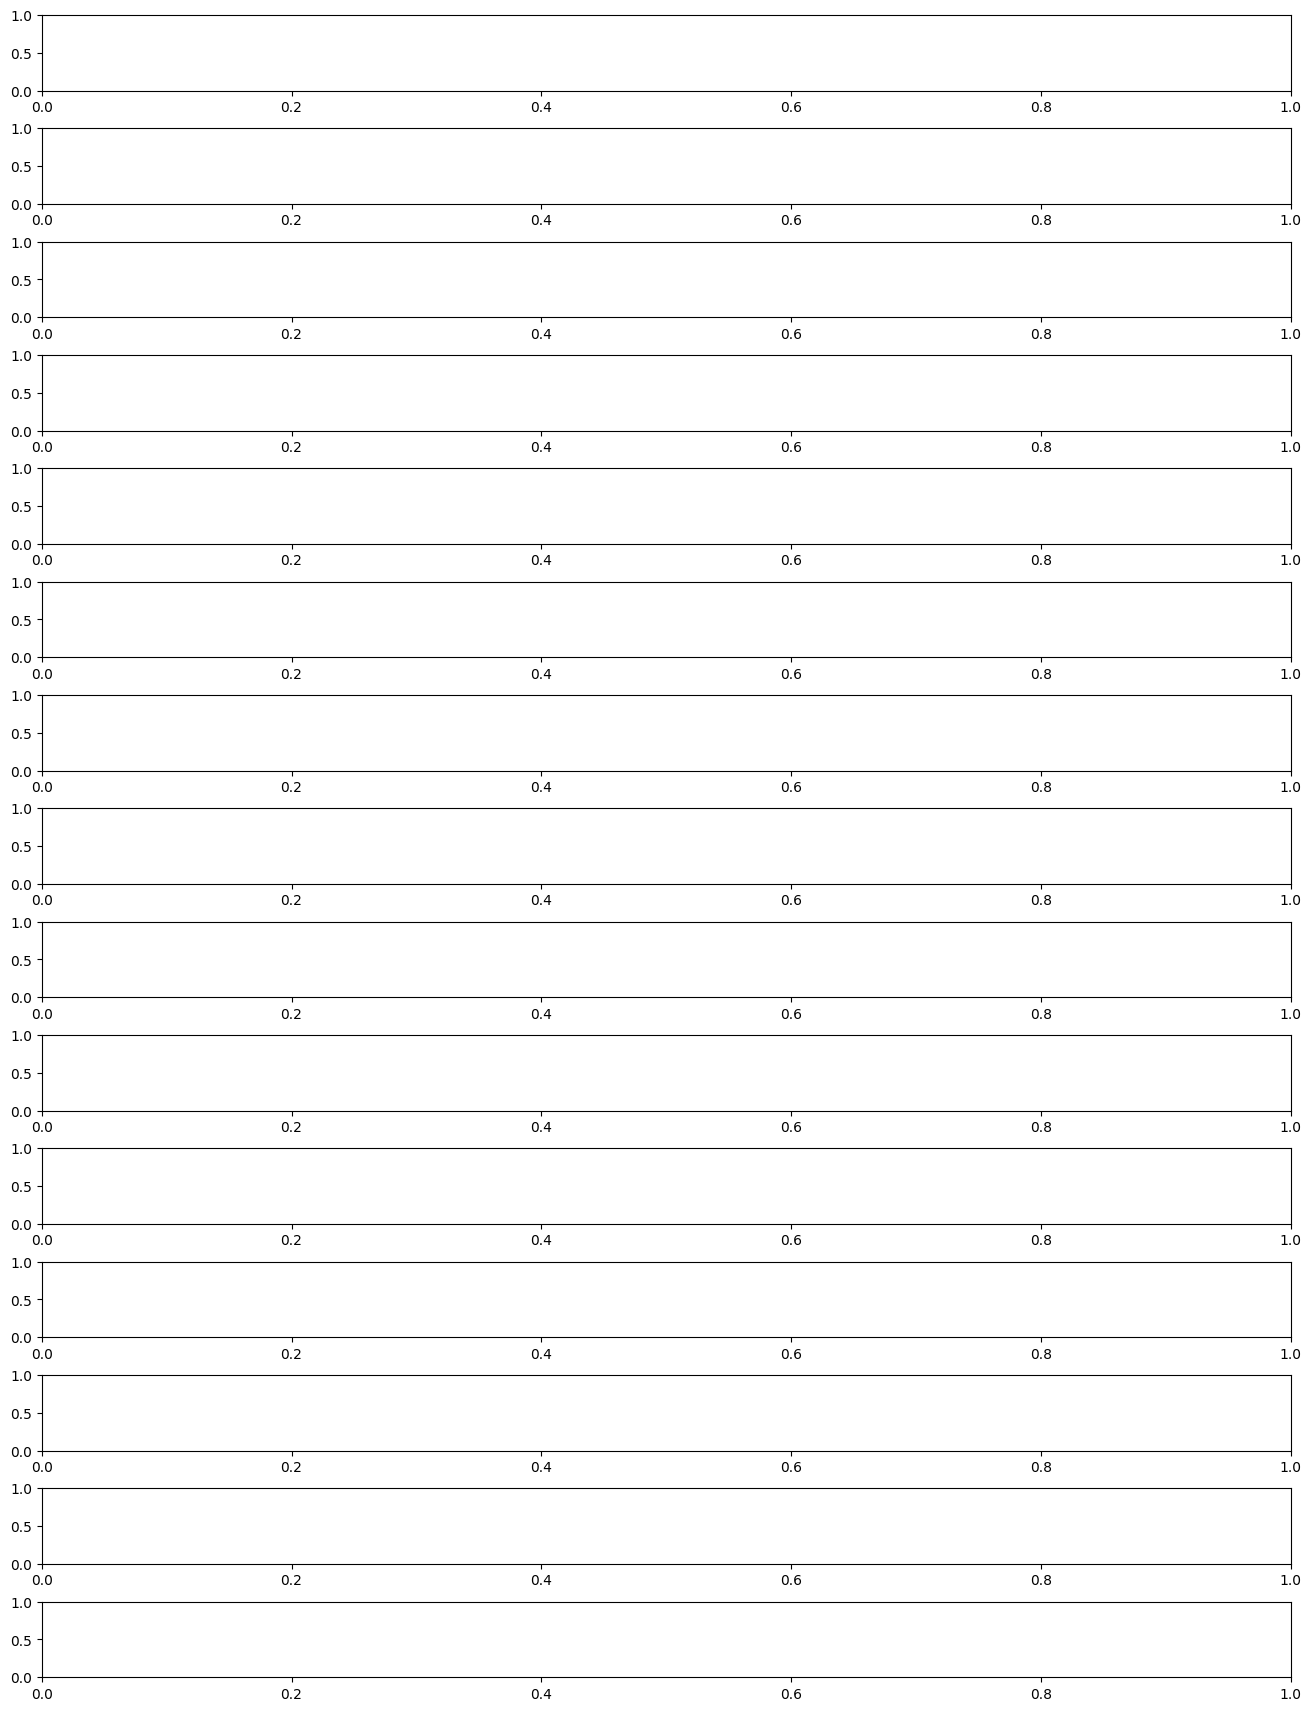

In [27]:
import copy
with T.no_grad():
    showgrid(image_batch, copy.copy(label_batch), copy.copy(heat_base_pred_batch), list_landmarks_gt, list_landmarks_pred)